<a href="https://colab.research.google.com/github/xbadiam/Marketing_Campaign/blob/main/notebooks/MarketingCampaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Campaña de marketing
Aumentar las ganancias de una campaña de marketing

### Contexto

Un modelo de respuesta puede aumentar significativamente la eficiencia de una campaña de marketing, ya sea incrementando las respuestas o reduciendo los gastos. El objetivo es predecir quién responderá a una oferta de un producto o servicio.

In [155]:
!rm -rf /content/Marketing_Campaign

! git clone https://github.com/xbadiam/Marketing_Campaign.git

Cloning into 'Marketing_Campaign'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 112 (delta 44), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 3.15 MiB | 5.67 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [156]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn import metrics

# Modelado
# ==============================================================================
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


## 3. Cargar datos

In [175]:
data = pd.read_csv('/content/Marketing_Campaign/outputs/output.csv')
data

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Has_child,Living_With,Children
0,Graduate,Single,58138.0,Without_Kid,Without_Teen,2012-09-04,58,635,88,546,...,0,0,0,0,1,68,1617,0,Single,0
1,Graduate,Single,46344.0,With_Kid,With_Teen,2014-03-08,38,11,1,6,...,0,0,0,0,0,71,27,1,Single,2
2,Graduate,Together,71613.0,Without_Kid,Without_Teen,2013-08-21,26,426,49,127,...,0,0,0,0,0,60,776,0,Partner,0
3,Graduate,Together,26646.0,With_Kid,Without_Teen,2014-02-10,26,11,4,20,...,0,0,0,0,0,41,53,1,Partner,1
4,Postgraduate,Married,58293.0,With_Kid,Without_Teen,2014-01-19,94,173,43,118,...,0,0,0,0,0,44,422,1,Partner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,Graduate,Married,61223.0,Without_Kid,With_Teen,2013-06-13,46,709,43,182,...,0,0,0,0,0,58,1341,1,Partner,1
2230,Postgraduate,Together,64014.0,With_Kid,With_Teen,2014-06-10,56,406,0,30,...,0,1,0,0,0,79,444,1,Partner,3
2231,Graduate,Divorced,56981.0,Without_Kid,Without_Teen,2014-01-25,91,908,48,217,...,0,0,0,0,0,44,1241,0,Single,0
2232,Postgraduate,Together,69245.0,Without_Kid,With_Teen,2014-01-24,8,428,30,214,...,0,0,0,0,0,69,843,1,Partner,1


In [158]:
print("Número de características:", len(data.columns))
print("Longitud del conjunto de datos:", len(data))

Número de características: 30
Longitud del conjunto de datos: 2234


In [159]:
# Visualizamos los tipos de cada uno de los atributos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2234 non-null   object 
 1   Marital_Status       2234 non-null   object 
 2   Income               2234 non-null   float64
 3   Kidhome              2234 non-null   object 
 4   Teenhome             2234 non-null   object 
 5   Dt_Customer          2234 non-null   object 
 6   Recency              2234 non-null   int64  
 7   MntWines             2234 non-null   int64  
 8   MntFruits            2234 non-null   int64  
 9   MntMeatProducts      2234 non-null   int64  
 10  MntFishProducts      2234 non-null   int64  
 11  MntSweetProducts     2234 non-null   int64  
 12  MntGoldProds         2234 non-null   int64  
 13  NumDealsPurchases    2234 non-null   int64  
 14  NumWebPurchases      2234 non-null   int64  
 15  NumCatalogPurchases  2234 non-null   i

## 4. Preprocesado

In [160]:
# Selección de las columnas numéricas y categóricas
# ==============================================================================

numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

In [177]:
# Preprocesamiento
# ==============================================================================

preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='drop')

## 5. Reducción de dimensionalidad (PCA)

In [178]:
# Pipeline PCA
pca_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

# Ajuste y transformación (devuelve matriz numpy)
X_pca = pca_pipeline.fit_transform(data)

# Extraer modelo PCA y componentes
pca_model = pca_pipeline.named_steps['pca']

In [179]:
print("Número de componentes retenidas:", pca_model.n_components_)
print("Varianza acumulada (último):", np.sum(pca_model.explained_variance_ratio_))

Número de componentes retenidas: 27
Varianza acumulada (último): 0.9527168749034798


Una vez calculadas las componentes principales, se puede conocer la varianza explicada por cada una de ellas, la proporción respecto al total y la proporción de varianza acumulada. Esta información está almacenada en los atributos explained_variance_ y explained_variance_ratio_ del modelo.

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.2924 0.083  0.0684 0.0506 0.0388 0.0366 0.0357 0.0335 0.0301 0.0283
 0.0271 0.0243 0.022  0.0215 0.0207 0.0174 0.0164 0.0158 0.0142 0.0133
 0.0123 0.0108 0.0106 0.0088 0.0078 0.0066 0.0058]


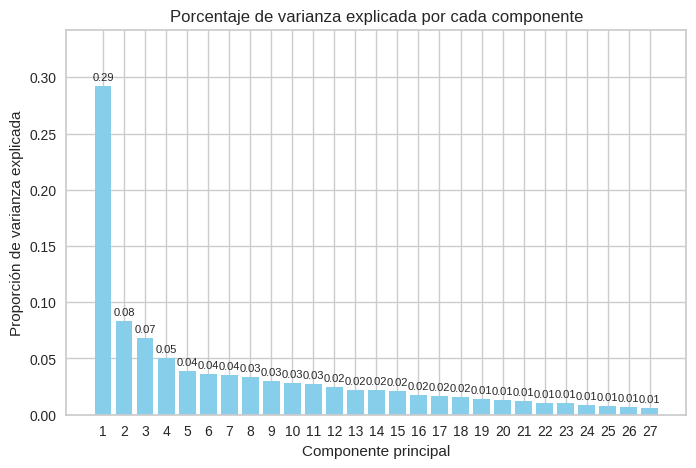

In [163]:
# Gráfico de los componentes
# ==============================================================================

print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')

print(np.round(pca_model.explained_variance_ratio_, 4))  # 4 decimales para claridad

# Obtenemos el objeto PCA del pipeline
pca_model = pca_pipeline.named_steps['pca']

# Gráfico de la varianza explicada
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    x=np.arange(pca_model.n_components_) + 1,
    height=pca_model.explained_variance_ratio_,
    color='skyblue'
)

# Etiquetas de porcentaje sobre las barras
for i, v in enumerate(pca_model.explained_variance_ratio_):
    ax.text(i + 1, v + 0.005, f"{v:.2f}", ha='center', fontsize=8)

ax.set_xticks(np.arange(pca_model.n_components_) + 1)
ax.set_ylim(0, max(pca_model.explained_variance_ratio_) + 0.05)
ax.set_title('Porcentaje de varianza explicada por cada componente', fontsize=12)
ax.set_xlabel('Componente principal')
ax.set_ylabel('Proporción de varianza explicada')
plt.show()


En este caso, la primera componente explica el 29% de la varianza observada en los datos y la segunda el 8%. Las dos últimas componentes no superan por separado el 1% de varianza explicada.

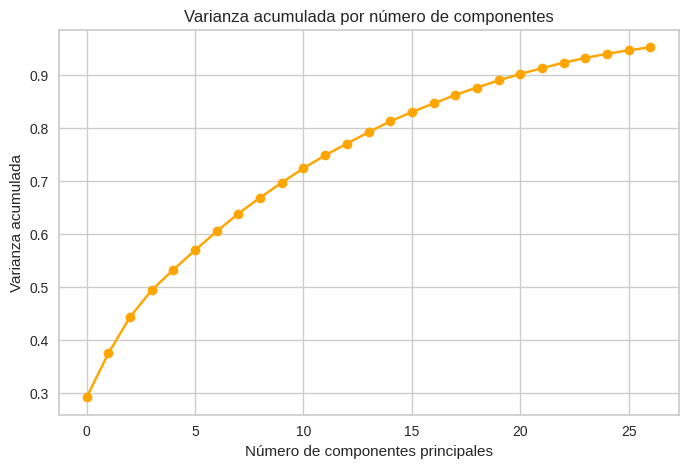

In [164]:
# Gráfico acumulativo
# ==============================================================================

plt.figure(figsize=(8, 5))
plt.plot(
    np.cumsum(pca_model.explained_variance_ratio_), marker='o', color='orange'
)
plt.title('Varianza acumulada por número de componentes')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

Si se empleasen 27 componentes se conseguiría explicar el 95% de la varianza observada.

In [165]:
# Gráfico de los componentes
# ==============================================================================

# Get the PCA estimator from the pipeline
pca_estimator = pca_pipeline.named_steps['pca']

# Calcular la varianza explicada acumulada
varianza_acumulada = np.cumsum(pca_estimator.explained_variance_ratio_)

In [166]:
# Imprimir resultados
for i, var in enumerate(varianza_acumulada):
    print(f"Componentes: {i+1}, Varianza explicada acumulada: {var:.2f}")

Componentes: 1, Varianza explicada acumulada: 0.29
Componentes: 2, Varianza explicada acumulada: 0.38
Componentes: 3, Varianza explicada acumulada: 0.44
Componentes: 4, Varianza explicada acumulada: 0.49
Componentes: 5, Varianza explicada acumulada: 0.53
Componentes: 6, Varianza explicada acumulada: 0.57
Componentes: 7, Varianza explicada acumulada: 0.61
Componentes: 8, Varianza explicada acumulada: 0.64
Componentes: 9, Varianza explicada acumulada: 0.67
Componentes: 10, Varianza explicada acumulada: 0.70
Componentes: 11, Varianza explicada acumulada: 0.72
Componentes: 12, Varianza explicada acumulada: 0.75
Componentes: 13, Varianza explicada acumulada: 0.77
Componentes: 14, Varianza explicada acumulada: 0.79
Componentes: 15, Varianza explicada acumulada: 0.81
Componentes: 16, Varianza explicada acumulada: 0.83
Componentes: 17, Varianza explicada acumulada: 0.85
Componentes: 18, Varianza explicada acumulada: 0.86
Componentes: 19, Varianza explicada acumulada: 0.88
Componentes: 20, Vari

In [181]:
# Creamos un DataFrame con componentes (sin cluster)
PCA_dataset = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(pca_model.n_components_)],
    index=data.index)

PCA_dataset.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,4.501882,-0.094988,-0.399081,2.056418,-0.256917,-0.221209,0.015546,-1.046802,-1.262022,2.124300,...,-1.439778,-0.108954,0.482702,0.002421,-0.587348,0.531140,0.554337,-0.289004,0.016047,-0.445268
1,-2.776196,0.128743,-0.157356,-0.791478,-1.296969,0.398762,-0.388052,0.881388,0.288314,0.915418,...,-0.380063,-0.388299,0.277346,-0.024403,-0.105992,-0.324650,0.116184,-0.306694,0.080446,-0.271599
2,2.143981,-0.734468,-1.100111,-0.283863,-0.549582,-0.903958,0.631328,-1.273107,0.394224,-0.092504,...,0.318452,0.241567,1.318295,0.996963,0.768314,-0.319237,0.016871,-0.554958,0.544586,-0.202886
3,-2.661001,-1.235059,0.130223,0.347337,0.473181,-0.709644,0.736625,0.472579,0.447377,-0.560747,...,-0.070799,-0.030699,0.536811,0.053357,0.966135,0.094521,0.345388,-0.126326,-0.332050,0.180783
4,-0.573153,0.416378,-0.796664,0.141727,1.820311,0.187651,-0.128987,0.591444,-0.563548,-0.696121,...,0.653563,0.247474,-0.498892,0.894659,-0.496684,-0.306686,0.563770,-0.286592,0.059799,0.662936


In [182]:
# Encontrar el número óptimo de componentes
n_componentes = np.argmax(varianza_acumulada >= 0.95) + 1

El resultado muestra que, para este conjunto de datos, son necesarios 27 componentes de los 30 totales para conservar el 95% de la varianza explicada.

## 6. Modelado: Clustering con Kmeans

En este apartado probamos el algorismo k-means sobre el dataset obtenido anteriorment, ajustando los parámetros adecuados, y analizando sus resultados.

Se utilizará el metodo Elbow para definir el número de clusters

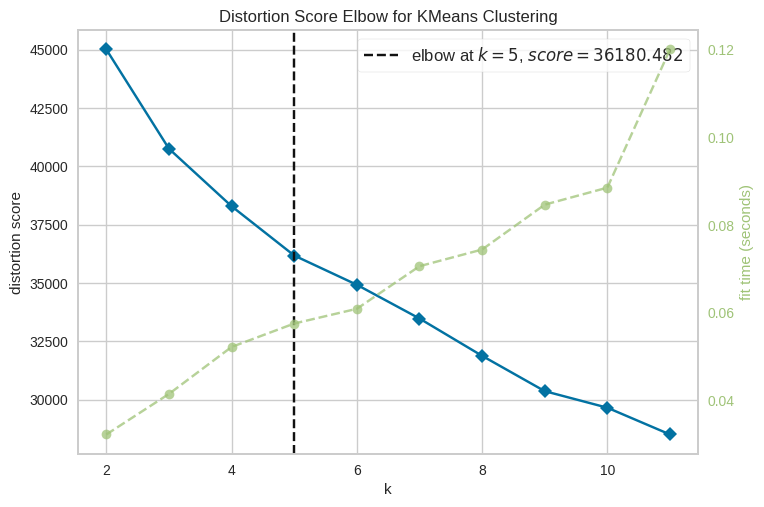

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [184]:
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(PCA_dataset)
visualizer.show()

La grafica muestra que el numero óptimo de cluesters son 6, por lo que se procedera a entrenar un modelo Kmeans el cual permita clasificar los datos.

In [170]:
kmeans = KMeans(n_clusters=6, random_state = 42)

Kmeans_clusters = kmeans.fit_predict(PCA_dataset)
PCA_dataset['Clusters'] = Kmeans_clusters

# Se agregaran los cluster sl dataset original
data['Clusters'] = Kmeans_clusters

In [171]:
data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Has_child,Living_With,Children,Clusters
0,Graduate,Single,58138.0,Without_Kid,Without_Teen,2012-09-04,58,635,88,546,...,0,0,0,1,68,1617,0,Single,0,5
1,Graduate,Single,46344.0,With_Kid,With_Teen,2014-03-08,38,11,1,6,...,0,0,0,0,71,27,1,Single,2,2
2,Graduate,Together,71613.0,Without_Kid,Without_Teen,2013-08-21,26,426,49,127,...,0,0,0,0,60,776,0,Partner,0,5
3,Graduate,Together,26646.0,With_Kid,Without_Teen,2014-02-10,26,11,4,20,...,0,0,0,0,41,53,1,Partner,1,2
4,Postgraduate,Married,58293.0,With_Kid,Without_Teen,2014-01-19,94,173,43,118,...,0,0,0,0,44,422,1,Partner,1,4


In [172]:
# Evaluamos los clusters y el contenido que se han formado
# ==============================================================================
counter = Counter(Kmeans_clusters.tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples".format(
        key, counter[key]))

Label 0 has 436 samples
Label 1 has 126 samples
Label 2 has 981 samples
Label 3 has 215 samples
Label 4 has 238 samples
Label 5 has 238 samples


----------------------------------------------------
Varianza explicada por lo componentes principales
----------------------------------------------------
[0.2924 0.083  0.0684 0.0506 0.0388 0.0366 0.0357 0.0335 0.0301 0.0283
 0.0271 0.0243 0.022  0.0215 0.0207 0.0174 0.0164 0.0158 0.0142 0.0133
 0.0123 0.0108 0.0106 0.0088 0.0078 0.0066 0.0058]

Varianza acumulada total: 0.9527


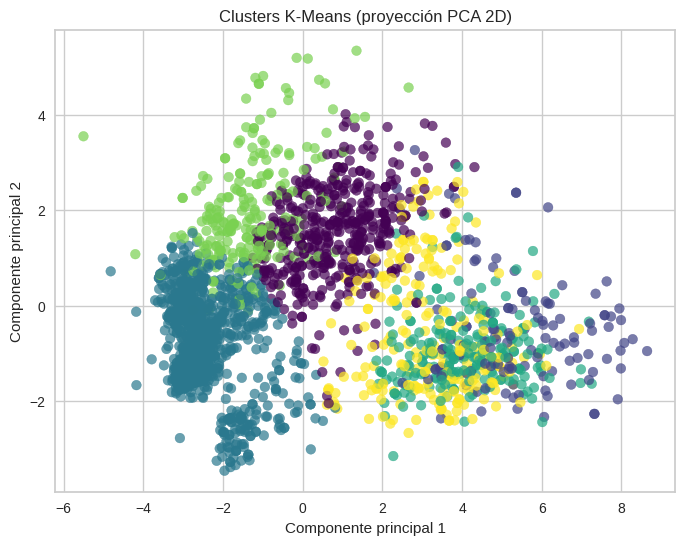

In [173]:
# Varianza explicada
print('----------------------------------------------------')
print('Varianza explicada por lo componentes principales')
print('----------------------------------------------------')
print(np.round(pca_model.explained_variance_ratio_, 4))
print(f"\nVarianza acumulada total: {np.sum(pca_model.explained_variance_ratio_):.4f}")

# 6️⃣ Representación en 2D (usando las dos primeras componentes)
X_pca_2d = pca_model.transform(
    pca_pipeline.named_steps['preprocess'].transform(data)
)[:, :2]

labels = Kmeans_clusters

plt.figure(figsize=(8,6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('Clusters K-Means (proyección PCA 2D)', fontsize=12)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid(True)
plt.show()

Ajuste y evaluación del modelo

 Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=10000))

In [174]:
#Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(PCA_dataset, Kmeans_clusters, sample_size=10000))

Shiloutte:  0.20720582060288398
